# Scikit-learn

ML 라이브러리 - 데이터 모델링에 필요한 대부분의 기능을 제공  
초보자를 위한 [ML Map](https://scikit-learn.org/stable/tutorial/machine_learning_map/) 제공  

ML 알고리즘별 API가 조금씩 다름; regression, classification, clustering  
크게 fit - predict 순으로 실행  

Transformer의 경우, fit - transform 순으로 실행  
* StandardScaler  
정규화 (subtract mean, divide by std-dev)  
* MinMaxScaler  
최소를 0, 최대를 1로 설정해서 scale
* PowerTransformer  
log1p와 유사? 구체적인 설명은 [블로그 포스트](https://machinelearningmastery.com/power-transforms-with-scikit-learn/) 참고  
* CountVectorizer  
단어 단위로 출현 횟수를 count
* TfidVectorizer  
단어 단위로 count하되 전체 data에서의 출현 빈도로 나누어 빈도가 낮은 단어의 출현에 가중치를 둠
* 이외에도 encoder, pca(dimension reduction) 등을 제공  

메트릭은 모델의 성능을 수치화해서 보여주는 역할  

검증에도 여러 전략이 존재하며 그 중 대표적인 것은
* Hold-out  
데이터셋 중 일부를 random하게 test_set으로 구분, 이때 random_state에 동일한 값을 주면 재현이 가능함  
* N-fold Cross Validation  
데이터셋을 N개로 나누어 각 set을 test_set으로 설정, N번의 학습 및 검증을 진행  
전체 데이터셋에 대해 모델의 성능을 검증할 수 있다는 장점  

# Decision Tree
일련의 결정 규칙에 기반한 예측 모델  
* 분류 학습  
  * 범주를 가장 잘 구분할 수 있는 변수와 그 기준값을 greedy search로 탐색  
  e.g. red shift를 기준으로 했을 때 class 0가 효과적으로 분리됨 - dered_z 등을 적용
  * 자주 쓰이는 손실함수는 Gini Impurity, Entropy - 확률이 50%일 때 손실이 최대 (그만큼 분리가 안됐다는 뜻?)   
* 회귀 학습
  * 손실함수 최소화하는 변수와 그 기준값을 탐색  

Depth를 늘려 더 디테일한 학습이 가능함; trade-off는?  
graphviz를 사용해서 시각화

In [5]:
import graphviz
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import warnings

In [6]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [7]:
from google.colab import files
files.upload()

Saving data.zip to data.zip


In [8]:
!unzip data.zip

Archive:  data.zip
   creating: open/
 extracting: open/sample_submission.csv  
 extracting: open/test.csv           
 extracting: open/train.csv          


In [9]:
!mkdir ./build

In [10]:
!ls

build  data.zip  open  sample_data


In [14]:

data_dir = Path('./open')
sub_dir = Path('./build')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
seed = 42

In [15]:
algo_name = 'dt'
feature_name = 'j1'
model_name = f'{algo_name}_{feature_name}'

sub_file = sub_dir / f'{model_name}.csv'

In [16]:
trn = pd.read_csv(trn_file, index_col=0)
tst = pd.read_csv(tst_file, index_col=0)
y = trn[target_col]
trn.drop(target_col, axis=1, inplace=True)
print(y.shape, trn.shape, tst.shape)
trn.head()

(320000,) (320000, 18) (80000, 18)


,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z
id,,,,,,,,,,,,,,,,,,
0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,18,1.1898,1.1907,1.1890,1.1894,1.1902
1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1,1.2533,1.2578,1.2488,1.2510,1.2555
2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,2,1.0225,1.0241,1.0210,1.0217,1.0233
3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,4,3,1.2054,1.2061,1.2049,1.2051,1.2057
4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,13,12,1.1939,1.1943,1.1937,1.1938,1.1941


In [22]:
clf = DecisionTreeClassifier(max_depth=4, min_samples_leaf=10, random_state=seed)
clf.fit(trn, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [23]:
print(f'{accuracy_score(y, clf.predict(trn)) * 100:.4f}%')

87.7628%


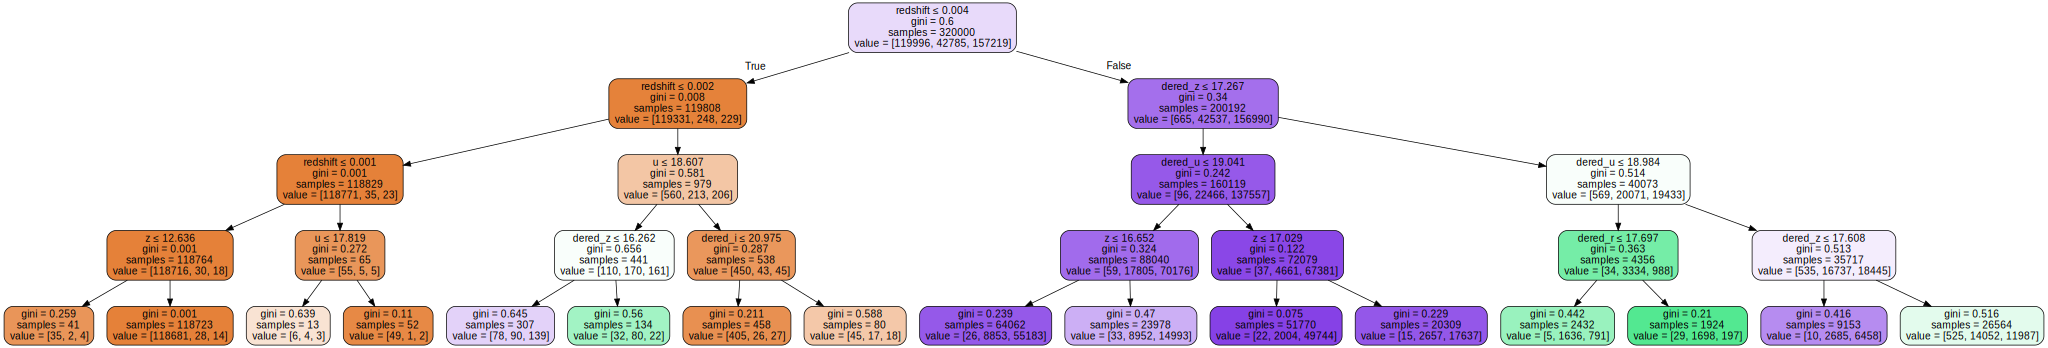

In [24]:
dot_data = export_graphviz(clf, out_file=None,
                           feature_names=trn.columns,
                           filled=True,
                           rounded=True,
                           special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

In [25]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [26]:
sub[target_col] = clf.predict(tst)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [27]:
sub[target_col].value_counts()

2    42289
0    29861
1     7850
Name: class, dtype: int64

In [31]:
sub.to_csv(sub_file)

In [32]:
!ls build

dt_j1.csv


In [35]:
from google.colab import files
files.download('./build/dt_j1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>